In [8]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [9]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)

    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
        scores.append(row["score"])
    #edges = sorted(edges)

    return edges,scores

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()

    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)

    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))

    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)

    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())

    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [10]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [11]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes,
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

def generate_second_order_random_walk(graph, alias_nodes, alias_edges,
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]

    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [12]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))

    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))

    return model

### Scorer

In [13]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)

    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)

def get_auc_score_test(model, edges,scores):
    """
    get the auc score
    """
    y_true = scores

    y_score = list()
    for e in edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)


def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)





def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [14]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(2024)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges + valid_edges, 40000 - len(valid_edges))
test_edges,test_scores = load_test_data(test_file)

number of nodes: 72795
number of edges: 100000
85407 120000


# Link Prediction

## deepwalk
### I broke into three cell in case any error happens

In [25]:
deepwalk_auc_scores_allCombination = dict()
node_dim_list = [i for i in range(20, 22)]
walk_length_list = [i for i in range(4, 7)] # 15    # 10    # 5     # 5
num_walks_list = [i for i in range(8, 12)]  # 5     # 10    # 10    # 10
p_list = [(float (i))/10 for i in range(5, 11, 2)]
q_list = [(float (i))/10 for i in range(5, 11, 2)]
best_deepwalk_auc = 0
best_deepwalk_para = [0, 0, 0, 0, 0]

for node_dim in node_dim_list:
    for p in p_list:
        for q in q_list:
            for num_walks in num_walks_list:
                for walk_length in walk_length_list:
                    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
                    model = build_deepwalk(graph, alias_nodes,
                                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
                    auc = get_auc_score(model, valid_edges, false_edges)
                    deepwalk_auc_scores_allCombination[(node_dim, num_walks, walk_length, p, q)] = auc
                    print("valid auc: %.4f" % (deepwalk_auc_scores_allCombination[(node_dim, num_walks, walk_length, p, q)]))
                    if (auc > best_deepwalk_auc):
                        best_deepwalk_auc = auc
                        best_deepwalk_para = node_dim, num_walks, walk_length, p, q
print("best_deepwalk: ")
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (best_deepwalk_para[0], best_deepwalk_para[1], best_deepwalk_para[2], best_deepwalk_para[3], best_deepwalk_para[4]), end="\t")
print("auc: %.4f" % best_deepwalk_auc)

node dim: 20,	num_walks: 8,	walk_length: 4, 	p: 0.50, 	q: 0.50	building a DeepWalk model...	number of walks: 582360	average walk length: 4.0000	training time: 19.2028
valid auc: 0.6661
node dim: 20,	num_walks: 8,	walk_length: 5, 	p: 0.50, 	q: 0.50	building a DeepWalk model...	number of walks: 582360	average walk length: 5.0000	training time: 23.3543
valid auc: 0.6733
node dim: 20,	num_walks: 8,	walk_length: 6, 	p: 0.50, 	q: 0.50	building a DeepWalk model...	number of walks: 582360	average walk length: 6.0000	training time: 27.4494
valid auc: 0.6765
node dim: 20,	num_walks: 9,	walk_length: 4, 	p: 0.50, 	q: 0.50	building a DeepWalk model...	number of walks: 655155	average walk length: 4.0000	training time: 21.4372
valid auc: 0.6728
node dim: 20,	num_walks: 9,	walk_length: 5, 	p: 0.50, 	q: 0.50	building a DeepWalk model...	number of walks: 655155	average walk length: 5.0000	training time: 26.4848
valid auc: 0.6750
node dim: 20,	num_walks: 9,	walk_length: 6, 	p: 0.50, 	q: 0.50	building a D

In [26]:
deepwalk_auc_scores_allCombination_second = dict()
node_dim_list = [i for i in range(21, 25)]
num_walks_list = [i for i in range(7, 10)]
walk_length_list = [i for i in range(4, 6)]
p_list = [(float (i))/10 for i in range(8, 11)]
q_list = [(float (i))/10 for i in range(6, 9)]
best_deepwalk_auc_second = 0
best_deepwalk_para_second = [0, 0, 0, 0, 0]

for node_dim in node_dim_list:
    for p in p_list:
        for q in q_list:
            for num_walks in num_walks_list:
                for walk_length in walk_length_list:
                    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
                    model = build_deepwalk(graph, alias_nodes,
                                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
                    auc = get_auc_score(model, valid_edges, false_edges)
                    deepwalk_auc_scores_allCombination_second[(node_dim, num_walks, walk_length, p, q)] = auc
                    print("valid auc: %.4f" % (deepwalk_auc_scores_allCombination_second[(node_dim, num_walks, walk_length, p, q)]))
                    if (auc > best_deepwalk_auc_second):
                        best_deepwalk_auc_second = auc
                        best_deepwalk_para_second = node_dim, num_walks, walk_length, p, q
print("best_deepwalk: ")
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (best_deepwalk_para_second[0], best_deepwalk_para_second[1], best_deepwalk_para_second[2], best_deepwalk_para_second[3], best_deepwalk_para_second[4]), end="\t")
print("auc: %.4f" % best_deepwalk_auc_second)

node dim: 21,	num_walks: 7,	walk_length: 4, 	p: 0.80, 	q: 0.60	building a DeepWalk model...	number of walks: 509565	average walk length: 4.0000	training time: 18.4100
valid auc: 0.6675
node dim: 21,	num_walks: 7,	walk_length: 5, 	p: 0.80, 	q: 0.60	building a DeepWalk model...	number of walks: 509565	average walk length: 5.0000	training time: 23.9198
valid auc: 0.6831
node dim: 21,	num_walks: 8,	walk_length: 4, 	p: 0.80, 	q: 0.60	building a DeepWalk model...	number of walks: 582360	average walk length: 4.0000	training time: 20.0446
valid auc: 0.6760
node dim: 21,	num_walks: 8,	walk_length: 5, 	p: 0.80, 	q: 0.60	building a DeepWalk model...	number of walks: 582360	average walk length: 5.0000	training time: 24.3047
valid auc: 0.6894
node dim: 21,	num_walks: 9,	walk_length: 4, 	p: 0.80, 	q: 0.60	building a DeepWalk model...	number of walks: 655155	average walk length: 4.0000	training time: 21.6281
valid auc: 0.6799
node dim: 21,	num_walks: 9,	walk_length: 5, 	p: 0.80, 	q: 0.60	building a D

### For better evaluation quality, I made another dict

In [84]:
deepwalk_auc_scores_increasing_nodeDim = dict()
node_dim_list = [i for i in range(20, 30)]
walk_length = 6
num_walks = 9
p = 0.9
q = 0.7
for node_dim in node_dim_list:
    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
    model = build_deepwalk(graph, alias_nodes,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
    auc = get_auc_score(model, valid_edges, false_edges)
    deepwalk_auc_scores_increasing_nodeDim[(node_dim, num_walks, walk_length, p, q)] = auc
    print("valid auc: %.4f" % (deepwalk_auc_scores_increasing_nodeDim[(node_dim, num_walks, walk_length, p, q)]))

node dim: 20,	num_walks: 9,	walk_length: 6, 	p: 0.90, 	q: 0.70	building a DeepWalk model...	number of walks: 655155	average walk length: 6.0000	training time: 32.5907
valid auc: 0.6770
node dim: 21,	num_walks: 9,	walk_length: 6, 	p: 0.90, 	q: 0.70	building a DeepWalk model...	number of walks: 655155	average walk length: 6.0000	training time: 33.4072
valid auc: 0.6827
node dim: 22,	num_walks: 9,	walk_length: 6, 	p: 0.90, 	q: 0.70	building a DeepWalk model...	number of walks: 655155	average walk length: 6.0000	training time: 36.5863
valid auc: 0.6902
node dim: 23,	num_walks: 9,	walk_length: 6, 	p: 0.90, 	q: 0.70	building a DeepWalk model...	number of walks: 655155	average walk length: 6.0000	training time: 34.1244
valid auc: 0.6927
node dim: 24,	num_walks: 9,	walk_length: 6, 	p: 0.90, 	q: 0.70	building a DeepWalk model...	number of walks: 655155	average walk length: 6.0000	training time: 32.5549
valid auc: 0.6993
node dim: 25,	num_walks: 9,	walk_length: 6, 	p: 0.90, 	q: 0.70	building a D

In [27]:
deepwalk_auc_scores_allCombination_third = dict()
node_dim_list = [i for i in range(24, 30)]
num_walks_list = [i for i in range(8, 11)]
walk_length_list = [i for i in range(4, 7)]
p_list = [(float (i))/100 for i in range(85, 100, 5)]
q_list = [(float (i))/100 for i in range(65, 80, 5)]
best_deepwalk_auc_third = 0
best_deepwalk_para_third = [0, 0, 0, 0, 0]

for node_dim in node_dim_list:
    for p in p_list:
        for q in q_list:
            for num_walks in num_walks_list:
                for walk_length in walk_length_list:
                    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
                    model = build_deepwalk(graph, alias_nodes,
                                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
                    auc = get_auc_score(model, valid_edges, false_edges)
                    deepwalk_auc_scores_allCombination_third[(node_dim, num_walks, walk_length, p, q)] = auc
                    print("valid auc: %.4f" % (deepwalk_auc_scores_allCombination_third[(node_dim, num_walks, walk_length, p, q)]))
                    if (auc > best_deepwalk_auc_third):
                        best_deepwalk_auc_third = auc
                        best_deepwalk_para_third = node_dim, num_walks, walk_length, p, q
print("best_deepwalk: ")
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (best_deepwalk_para_third[0], best_deepwalk_para_third[1], best_deepwalk_para_third[2], best_deepwalk_para_third[3], best_deepwalk_para_third[4]), end="\t")
print("auc: %.4f" % best_deepwalk_auc_third)

node dim: 24,	num_walks: 8,	walk_length: 4, 	p: 0.85, 	q: 0.65	building a DeepWalk model...	number of walks: 582360	average walk length: 4.0000	training time: 20.1205
valid auc: 0.6930
node dim: 24,	num_walks: 8,	walk_length: 5, 	p: 0.85, 	q: 0.65	building a DeepWalk model...	number of walks: 582360	average walk length: 5.0000	training time: 23.8078
valid auc: 0.7035
node dim: 24,	num_walks: 8,	walk_length: 6, 	p: 0.85, 	q: 0.65	building a DeepWalk model...	number of walks: 582360	average walk length: 6.0000	training time: 29.8852
valid auc: 0.7009
node dim: 24,	num_walks: 9,	walk_length: 4, 	p: 0.85, 	q: 0.65	building a DeepWalk model...	number of walks: 655155	average walk length: 4.0000	training time: 21.5919
valid auc: 0.6978
node dim: 24,	num_walks: 9,	walk_length: 5, 	p: 0.85, 	q: 0.65	building a DeepWalk model...	number of walks: 655155	average walk length: 5.0000	training time: 27.3474
valid auc: 0.7071
node dim: 24,	num_walks: 9,	walk_length: 6, 	p: 0.85, 	q: 0.65	building a D

## Using deep-walk on testing data

In [31]:
node_dim = 29
num_walks = 10
walk_length = 5
p = 0.85
q = 0.70
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)  # TODO
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a node2vec model...	number of walks: 727950	average walk length: 5.0000	training time: 37.9360


In [32]:
get_auc_score_test(model, test_edges, test_scores)

0.6340393174999999

## node2vec
### I broke into three cells in case any error happens

In [36]:
node2vec_auc_scores_allCombination = dict()
node_dim_list = [i for i in range(27, 31)]
num_walks_list = [i for i in range(8, 11)]
walk_length_list = [i for i in range(4, 7)]
p_list = [(float (i))/100 for i in range(85, 100, 5)]
q_list = [(float (i))/100 for i in range(65, 80, 5)]
best_node2vec_auc = 0
best_node2vec_para = [0, 0, 0, 0, 0]

for node_dim in node_dim_list:
    for p in p_list:
        for q in q_list:
            for num_walks in num_walks_list:
                for walk_length in walk_length_list:
                    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
                    model = build_node2vec(graph, alias_nodes, alias_edges,
                                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
                    auc = get_auc_score(model, valid_edges, false_edges)
                    node2vec_auc_scores_allCombination[(node_dim, num_walks, walk_length, p, q)] = auc
                    print("valid auc: %.4f" % (node2vec_auc_scores_allCombination[(node_dim, num_walks, walk_length, p, q)]))
                    if (auc > best_node2vec_auc):
                        best_node2vec_auc = auc
                        best_node2vec_para = node_dim, num_walks, walk_length, p, q
print("best_node2vec: ")
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (best_node2vec_para[0], best_node2vec_para[1], best_node2vec_para[2], best_node2vec_para[3], best_node2vec_para[4]), end="\t")
print("auc: %.4f" % best_node2vec_auc)

node dim: 27,	num_walks: 8,	walk_length: 4, 	p: 0.85, 	q: 0.65	building a node2vec model...	number of walks: 582360	average walk length: 4.0000	training time: 21.3940
valid auc: 0.7058
node dim: 27,	num_walks: 8,	walk_length: 5, 	p: 0.85, 	q: 0.65	building a node2vec model...	number of walks: 582360	average walk length: 5.0000	training time: 26.4069
valid auc: 0.7197
node dim: 27,	num_walks: 8,	walk_length: 6, 	p: 0.85, 	q: 0.65	building a node2vec model...	number of walks: 582360	average walk length: 6.0000	training time: 30.3639
valid auc: 0.7179
node dim: 27,	num_walks: 9,	walk_length: 4, 	p: 0.85, 	q: 0.65	building a node2vec model...	number of walks: 655155	average walk length: 4.0000	training time: 23.5257
valid auc: 0.7084
node dim: 27,	num_walks: 9,	walk_length: 5, 	p: 0.85, 	q: 0.65	building a node2vec model...	number of walks: 655155	average walk length: 5.0000	training time: 29.5986
valid auc: 0.7157
node dim: 27,	num_walks: 9,	walk_length: 6, 	p: 0.85, 	q: 0.65	building a n

In [38]:
node2vec_auc_scores_allCombinationS_second = dict()
node_dim_list = [i for i in range(31, 51)]
num_walks_list = [9, 10]
walk_length_list = [5, 6]
p_list = [0.85, 0.90]
q_list = [0.70, 0.75]
best_node2vec_auc_second = 0
best_node2vec_para_second = [0, 0, 0, 0, 0]

for node_dim in node_dim_list:
    for p in p_list:
        for q in q_list:
            for num_walks in num_walks_list:
                for walk_length in walk_length_list:
                    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
                    model = build_node2vec(graph, alias_nodes, alias_edges,
                                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
                    auc = get_auc_score(model, valid_edges, false_edges)
                    node2vec_auc_scores_allCombinationS_second[(node_dim, num_walks, walk_length, p, q)] = auc
                    print("valid auc: %.4f" % (node2vec_auc_scores_allCombinationS_second[(node_dim, num_walks, walk_length, p, q)]))
                    if (auc > best_node2vec_auc_second):
                        best_node2vec_auc_second = auc
                        best_node2vec_para_second = node_dim, num_walks, walk_length, p, q
print("best_node2vec: ")
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (best_node2vec_para_second[0], best_node2vec_para_second[1], best_node2vec_para_second[2], best_node2vec_para_second[3], best_node2vec_para_second[4]), end="\t")
print("auc: %.4f" % best_node2vec_auc_second)

node dim: 31,	num_walks: 9,	walk_length: 5, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 655155	average walk length: 5.0000	training time: 31.5674
valid auc: 0.7366
node dim: 31,	num_walks: 9,	walk_length: 6, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 655155	average walk length: 6.0000	training time: 35.9631
valid auc: 0.7324
node dim: 31,	num_walks: 10,	walk_length: 5, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 727950	average walk length: 5.0000	training time: 35.6076
valid auc: 0.7382
node dim: 31,	num_walks: 10,	walk_length: 6, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 727950	average walk length: 6.0000	training time: 40.8711
valid auc: 0.7383
node dim: 31,	num_walks: 9,	walk_length: 5, 	p: 0.85, 	q: 0.75	building a node2vec model...	number of walks: 655155	average walk length: 5.0000	training time: 33.5364
valid auc: 0.7379
node dim: 31,	num_walks: 9,	walk_length: 6, 	p: 0.85, 	q: 0.75	building a

In [59]:
node2vec_auc_scores_allCombinationS_third = dict()
node_dim_list = [i for i in range(50, 131, 10)]
num_walks_list = [9, 10]
walk_length_list = [5, 6]
p_list = [0.85, 0.90]
q_list = [0.70, 0.75]
best_node2vec_auc_third = 0
best_node2vec_para_third = [0, 0, 0, 0, 0]

for node_dim in node_dim_list:
    for p in p_list:
        for q in q_list:
            for num_walks in num_walks_list:
                for walk_length in walk_length_list:
                    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
                    model = build_node2vec(graph, alias_nodes, alias_edges,
                                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
                    auc = get_auc_score(model, valid_edges, false_edges)
                    node2vec_auc_scores_allCombinationS_third[(node_dim, num_walks, walk_length, p, q)] = auc
                    print("valid auc: %.4f" % (node2vec_auc_scores_allCombinationS_third[(node_dim, num_walks, walk_length, p, q)]))
                    if (auc > best_node2vec_auc_third):
                        best_node2vec_auc_third = auc
                        best_node2vec_para_third = node_dim, num_walks, walk_length, p, q
print("best_node2vec: ")
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d, \tp: %.2f, \tq: %.2f" % (best_node2vec_para_third[0], best_node2vec_para_third[1], \
    best_node2vec_para_third[2], best_node2vec_para_third[3], best_node2vec_para_third[4]), end="\t")
print("auc: %.4f" % best_node2vec_auc_third)

node dim: 50,	num_walks: 9,	walk_length: 5, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 655155	average walk length: 5.0000	training time: 79.2164
valid auc: 0.7875
node dim: 50,	num_walks: 9,	walk_length: 6, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 655155	average walk length: 6.0000	training time: 43.8016
valid auc: 0.7868
node dim: 50,	num_walks: 10,	walk_length: 5, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 727950	average walk length: 5.0000	training time: 43.7205
valid auc: 0.7882
node dim: 50,	num_walks: 10,	walk_length: 6, 	p: 0.85, 	q: 0.70	building a node2vec model...	number of walks: 727950	average walk length: 6.0000	training time: 46.9532
valid auc: 0.7912
node dim: 50,	num_walks: 9,	walk_length: 5, 	p: 0.85, 	q: 0.75	building a node2vec model...	number of walks: 655155	average walk length: 5.0000	training time: 37.5722
valid auc: 0.7860
node dim: 50,	num_walks: 9,	walk_length: 6, 	p: 0.85, 	q: 0.75	building a

## Final prediction
### Use node2vec with found hyperparameters on the testing data

In [60]:
node_dim = 130 
num_walks = 9
walk_length = 5
p = 0.90
q = 0.75
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)  # TODO
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a node2vec model...	number of walks: 655155	average walk length: 5.0000	training time: 49.5130


In [61]:
get_auc_score_test(model, test_edges, test_scores)

0.70240713

# Evaluation of the results

Text(0, 0.5, 'num_walks')

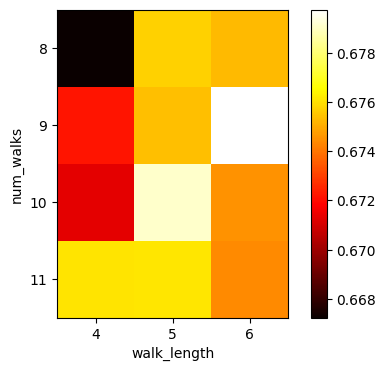

In [72]:
plt.figure(figsize=(6, 4))
node_dim = 20
walk_length_list = [i for i in range(4, 7)] # 15    # 10    # 5     # 5
num_walks_list = [i for i in range(8, 12)]  # 5     # 10    # 10    # 10
a = np.array([[deepwalk_auc_scores_allCombination[(node_dim, num_walks, walk_length, 0.9, 0.7)] for walk_length in walk_length_list] for num_walks in num_walks_list])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=walk_length_list)
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=num_walks_list)
plt.ylabel("num_walks")

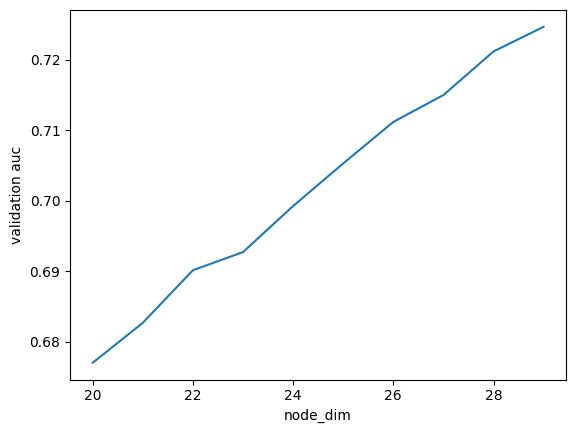

In [86]:
x = [i for i in range(20, 30)]
y = [deepwalk_auc_scores_increasing_nodeDim[(i, 9, 6, 0.9, 0.7)] for i in range(20, 30)]
plt.plot(x, y)
plt.xlabel("node_dim")
plt.ylabel("validation auc")
plt.show()

Text(0, 0.5, 'q')

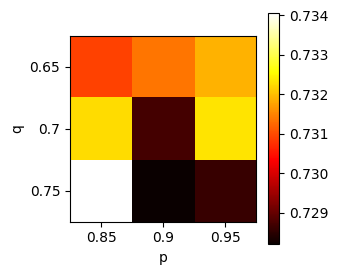

In [89]:
plt.figure(figsize=(3, 3))
node_dim = 30
walk_length = 6
num_walks = 9
p_list = [(float (i))/100 for i in range(85, 100, 5)]
q_list = [(float (i))/100 for i in range(65, 80, 5)]
a = np.array([[node2vec_auc_scores_allCombination[(node_dim, num_walks, walk_length, p, q)] for p in p_list] for q in q_list])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=p_list)
plt.xlabel("p")
plt.yticks(ticks=[0,1,2], labels=q_list)
plt.ylabel("q")

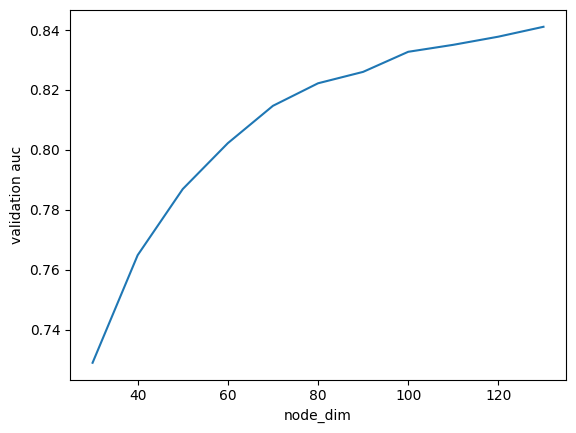

In [101]:
node2vec_validAcc_increasingNodeDim = []
node2vec_validAcc_increasingNodeDim.append(node2vec_auc_scores_allCombination[30, 9, 5, 0.90, 0.75])
node2vec_validAcc_increasingNodeDim.append(node2vec_auc_scores_allCombinationS_second[40, 9, 5, 0.90, 0.75])
for i in range(50, 131, 10):
    node2vec_validAcc_increasingNodeDim.append(node2vec_auc_scores_allCombinationS_third[i, 9, 5, 0.90, 0.75])
x = [i for i in range(30, 131, 10)]
y = node2vec_validAcc_increasingNodeDim
plt.plot(x, y)
plt.xlabel("node_dim")
plt.ylabel("validation auc")
plt.show()